In [ ]:
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from IPython.display import clear_output
from torch.utils.data import TensorDataset, DataLoader, Dataset
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [53]:
!nvidia-smi

Mon Jul 28 00:38:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   39C    P8              4W /   80W |     941MiB /   8188MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [25]:
%matplotlib inline

In [ ]:
!unzip rus-eng.zip

--2020-04-02 06:51:04--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.87.92, 54.192.87.42, 54.192.87.67, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.87.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  17.6MB/s    in 0.2s    

2020-04-02 06:51:04 (17.6 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [ ]:
!mv rus.txt eng-rus.txt

In [ ]:
!tail eng-rus.txt

Five tremors in excess of magnitude 5.0 on the Richter scale have shaken Japan just this week, but scientists are warning that the largest expected aftershock has yet to hit.	Cinq secousses dépassant la magnitude cinq sur l'échelle de Richter ont secoué le Japon précisément cette semaine, mais les scientifiques avertissent que la plus grande réplique est encore à venir.
No matter how much you try to convince people that chocolate is vanilla, it'll still be chocolate, even though you may manage to convince yourself and a few others that it's vanilla.	Peu importe le temps que tu passeras à essayer de convaincre les gens que le chocolat est de la vanille, ça restera toujours du chocolat, même si tu réussis à convaincre toi et quelques autres que c'est de la vanille.
A child who is a native speaker usually knows many things about his or her language that a non-native speaker who has been studying for years still does not know and perhaps will never know.	Un enfant qui est un locuteur natif

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    parts = s.split('\t')[:2]

    result = []
    for part in parts:
        normalized = unicodedata.normalize('NFC', part)
        result.append(normalized)
        
    return '\t'.join(result)

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-Яйё.!?]+", r" ", s)
    return s

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 519900 sentence pairs
Trimmed to 30087 sentence pairs
Counting words...
Counted words:
rus 10529
eng 4377
['вы отличный работник .', 'you re a great employee .']


The Encoder
-----------





In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, model_type="GRU"):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.model_type = model_type

        self.embedding = nn.Embedding(input_size, hidden_size)
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = embedded
        output, hidden = self.rnn(output, hidden)
        return output, hidden

    def initHidden(self, batch_size=1):
        if self.model_type == "LSTM":
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

The Decoder
-----------




In [8]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, model_type="GRU", dropout_p=0.1, max_length=MAX_LENGTH, attn_type="mlp"):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.model_type = model_type
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.attn_type = attn_type

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        if attn_type == "mlp":
            self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.GRU(self.hidden_size, self.hidden_size, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        if self.attn_type == "dot":
            attn_weights = F.softmax(torch.bmm(hidden[0].unsqueeze(1), encoder_outputs.transpose(1, 2)).squeeze(1), dim=1)
        else:  # mlp
            attn_weights = F.softmax(self.attn(torch.cat((embedded.view(-1, self.hidden_size), hidden[0]), 1)), dim=1)
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        output = torch.cat((embedded.view(-1, self.hidden_size), attn_applied.squeeze(1)), 1)
        output = self.attn_combine(output).unsqueeze(1)
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)
        output = F.log_softmax(self.out(output.squeeze(1)), dim=1)
        return output, hidden, attn_weights

    def initHidden(self, batch_size=1):
        if self.model_type == "LSTM":
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

In [9]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [10]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    batch_size = input_tensor.size(0)
    encoder_hidden = encoder.initHidden(batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)

    encoder_outputs = torch.zeros(batch_size, max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[:, ei, :], encoder_hidden)
        encoder_outputs[:, ei, :] = encoder_output.squeeze(1)

    decoder_input = torch.tensor([[SOS_token]] * batch_size, device=device).view(batch_size, 1)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[:, di, :].squeeze(1))
            decoder_input = target_tensor[:, di, :]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topi = decoder_output.topk(1)
            decoder_input = topi.detach() # detach from history as input

            loss += criterion(decoder_output, target_tensor[:, di, :].squeeze(1))
            if (decoder_input == EOS_token).all():
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def trainIters(encoder, decoder, n_iters, name, batch_size=8, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    training_pairs = [tensorsFromPair(random.choice(pairs)) for _ in range(n_iters)]
    input_tensors = nn.utils.rnn.pad_sequence([pair[0] for pair in training_pairs], batch_first=True, padding_value=0)
    target_tensors = nn.utils.rnn.pad_sequence([pair[1] for pair in training_pairs], batch_first=True, padding_value=0)
    dataset = TensorDataset(input_tensors, target_tensors)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.NLLLoss()
    iter_count = 0

    for _ in range(1, (n_iters // batch_size) + 1):
        for batch_input, batch_target in dataloader:
            if iter_count >= n_iters:
                break

            loss = train(batch_input, batch_target, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss * batch_input.size(0)
            plot_loss_total += loss * batch_input.size(0)
            iter_count += batch_input.size(0)

            if iter_count % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter_count / n_iters), iter_count, iter_count / n_iters * 100, print_loss_avg))

            if iter_count % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

    showPlot(plot_losses, name=name)

    return plot_losses

In [13]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points, name):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.savefig(name)

In [14]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_tensor = input_tensor.view(1, -1, 1)
        input_length = input_tensor.size(1)

        encoder_hidden = encoder.initHidden(batch_size=1)

        encoder_outputs = torch.zeros(1, max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[:, ei, :], encoder_hidden)
            encoder_outputs[:, ei, :] = encoder_output.squeeze(1)

        decoder_input = torch.tensor([[SOS_token]], device=device).view(1, 1)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topi = decoder_output.data.topk(1)
            decoder_attentions[di] = decoder_attention.data
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [15]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [17]:
def evaluate_bleu(encoder, decoder, pairs):
    references = []
    hypotheses = []
    for pair in pairs:
        input_tensor, target_tensor = tensorsFromPair(pair)
        output_words = evaluate(encoder, decoder, input_tensor)
        references.append([pair[1].split()])
        hypotheses.append(output_words.split())
    return corpus_bleu(references, hypotheses)

# **Attention with cosine similarity**

In [16]:
hidden_size = 256

encoder_dot = EncoderRNN(input_lang.n_words, hidden_size, num_layers=1, model_type="GRU").to(device)
decoder_dot = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1, num_layers=1, model_type="GRU", attn_type="dot").to(device)

trainIters(encoder_dot, decoder_dot, 150000, name="dot_product_attn_GRU_1_layer.png", batch_size=1, print_every=10000, plot_every=5000)

2m 40s (- 37m 21s) (10000 6%) 2.3720
5m 14s (- 34m 6s) (20000 13%) 1.8860
7m 48s (- 31m 15s) (30000 20%) 1.6303
10m 21s (- 28m 30s) (40000 26%) 1.4487
12m 55s (- 25m 50s) (50000 33%) 1.3183
15m 26s (- 23m 9s) (60000 40%) 1.2111
17m 48s (- 20m 21s) (70000 46%) 1.1223
20m 7s (- 17m 36s) (80000 53%) 1.0336
22m 25s (- 14m 56s) (90000 60%) 0.9663
24m 47s (- 12m 23s) (100000 66%) 0.9222
27m 12s (- 9m 53s) (110000 73%) 0.8613
29m 36s (- 7m 24s) (120000 80%) 0.8148
32m 13s (- 4m 57s) (130000 86%) 0.7917
34m 50s (- 2m 29s) (140000 93%) 0.7631
37m 29s (- 0m 0s) (150000 100%) 0.6897


In [33]:
evaluateRandomly(encoder_dot, decoder_dot, 20)

> он с ума по ней сходит .
= he s crazy about her .
< he is crazy about her . . <EOS>

> я не для тебя это делаю .
= i m not doing this for you .
< i m not doing that for you . <EOS>

> я тоже молодой .
= i m young too .
< i m young too too too . <EOS>

> вы популярны .
= you re popular .
< you re working and i have <EOS>

> я уверен что том вас ждёт .
= i m sure tom is waiting for you .
< i m sure tom is waiting for you . <EOS>

> они быстрые .
= they re fast .
< they re planning to have <EOS>

> я точно не знаю что происходит .
= i m not sure what s going on .
< i m not sure what what . <EOS>

> они читают их газеты .
= they re reading their newspapers .
< they re reading their and they . . SOS SOS

> вы ведь по прежнему учитель ?
= you re still a teacher aren t you ?
< you re still your teacher aren t you ? <EOS>

> она гребёт деньги лопатой .
= she s making money hand over fist .
< she is good at money in money . <EOS>

> я начинаю чувствовать себя лучше .
= i m starting to feel be

input = я устал быть осторожным .
output = i m tired of being tired of being careful .


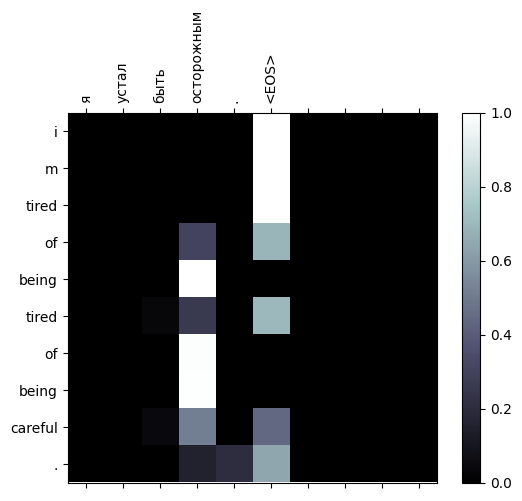

input = боюсь я вас обидел .
output = i m afraid your intentions t . . <EOS>


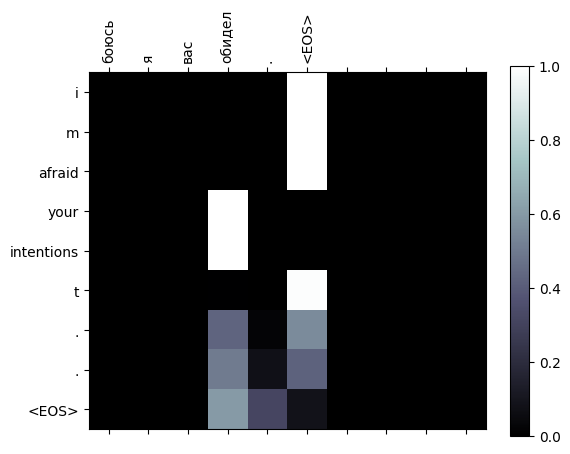

input = она толстая женщина среднего возраста .
output = she is expecting her two than his . . <EOS>


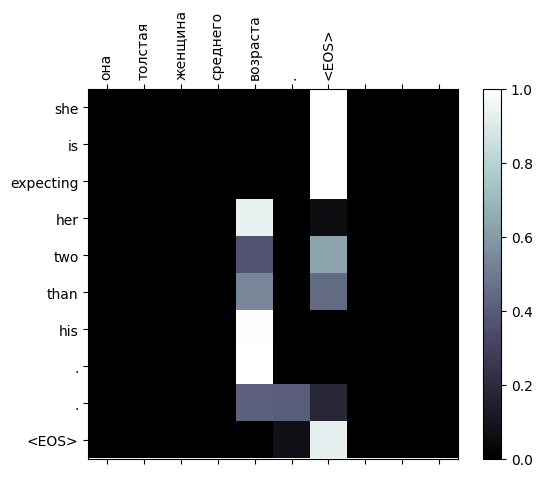

input = я беспокоюсь что вы заблудитесь .
output = i m convinced you can waiting . <EOS>


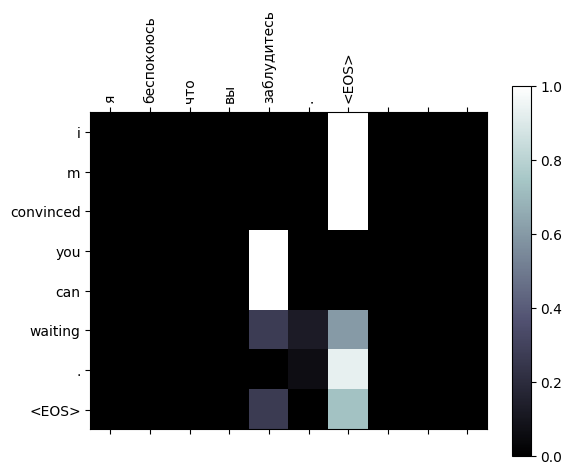

In [89]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    ax.set_xticks(range(len(input_sentence.split(' ')) + 1))
    ax.set_yticks(range(len(output_words)))

    # Set up axes
    ax.set_xticklabels(input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels(output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(encoder, decoder, input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention(encoder_dot, decoder_dot, "я устал быть осторожным .")

evaluateAndShowAttention(encoder_dot, decoder_dot, "боюсь я вас обидел .")

evaluateAndShowAttention(encoder_dot, decoder_dot, "она толстая женщина среднего возраста .")

evaluateAndShowAttention(encoder_dot, decoder_dot, "я беспокоюсь что вы заблудитесь .")

# **Attention with MLP**

3m 2s (- 42m 28s) (10000 6%) 2.3232
5m 48s (- 37m 45s) (20000 13%) 1.8623
8m 29s (- 33m 58s) (30000 20%) 1.6251
11m 20s (- 31m 12s) (40000 26%) 1.4660
14m 13s (- 28m 26s) (50000 33%) 1.3305
17m 9s (- 25m 44s) (60000 40%) 1.2320
20m 2s (- 22m 53s) (70000 46%) 1.1587
22m 45s (- 19m 54s) (80000 53%) 1.0725
25m 30s (- 17m 0s) (90000 60%) 1.0226
28m 22s (- 14m 11s) (100000 66%) 0.9804
31m 6s (- 11m 18s) (110000 73%) 0.9348
33m 51s (- 8m 27s) (120000 80%) 0.8985
36m 40s (- 5m 38s) (130000 86%) 0.8739
39m 35s (- 2m 49s) (140000 93%) 0.8356
42m 22s (- 0m 0s) (150000 100%) 0.8144


<Figure size 640x480 with 0 Axes>

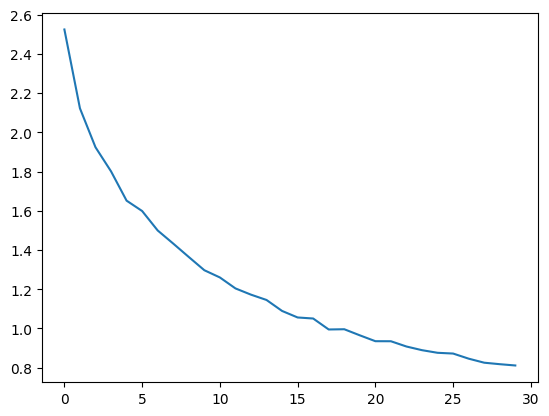

In [36]:
hidden_size = 256

encoder_mlp = EncoderRNN(input_lang.n_words, hidden_size, num_layers=1, model_type="GRU").to(device)
decoder_mlp = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1, num_layers=1, model_type="GRU", attn_type="mlp").to(device)

trainIters(encoder_mlp, decoder_mlp, 150000, name="mlp_attn_GRU_1_layer.png", batch_size=1, print_every=10000, plot_every=5000)

In [47]:
evaluateRandomly(encoder_mlp, decoder_mlp, 20)

> мне не разрешают так делать .
= i m not allowed to do so .
< i m not going to do you . . <EOS>

> я пытаюсь тебя подбодрить .
= i m trying to cheer you up .
< i m trying to cheer you . <EOS>

> я сделаю это следующей осенью .
= i m going to do that next fall .
< i m going to do that this next next <EOS>

> ты же не торопишься ?
= you aren t in a hurry are you ?
< you aren t in a hurry are much . <EOS>

> ты совсем не в моём вкусе .
= you re not my type at all .
< you re not very good at . <EOS>

> я рад что это был не я .
= i m glad it wasn t me .
< i m glad it was t . <EOS>

> я богаче вас .
= i m richer than you .
< i m richer to write you . . <EOS>

> я свободна каждый день кроме понедельника .
= i m free every day but monday .
< i m free every day tom monday . <EOS>

> мне стыдно за поведение моего сына .
= i am ashamed of my son s conduct .
< he is so with of her mother . <EOS>

> вы аморальны .
= you re immoral .
< you re really trying to get married . <EOS>

> я не настолько н

input = я устал быть осторожным .
output = i m tired of being careful . <EOS>


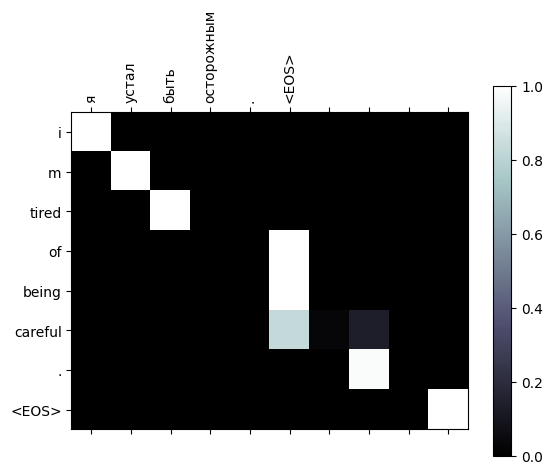

input = боюсь я вас обидел .
output = i m afraid i ve offended . <EOS>


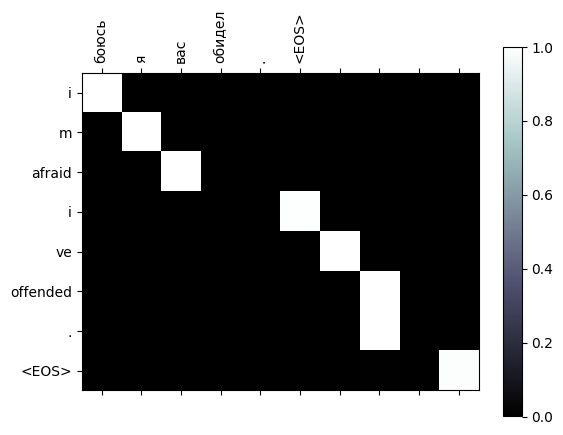

input = она толстая женщина среднего возраста .
output = she is really pretty since to be . . <EOS>


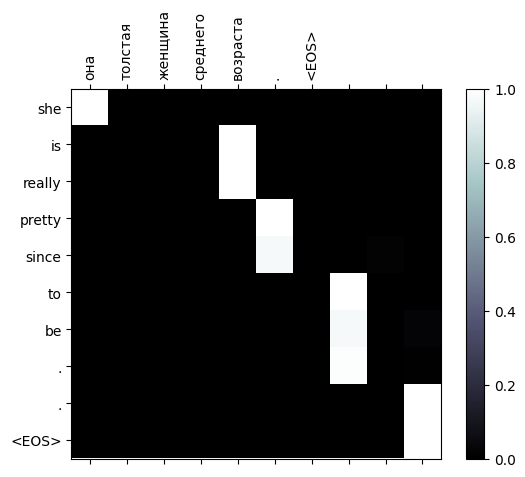

input = я беспокоюсь что вы заблудитесь .
output = i m worried you you get lost . <EOS>


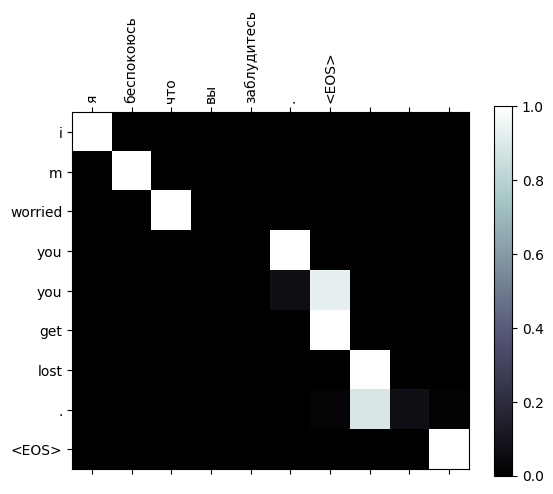

In [63]:
evaluateAndShowAttention(encoder_mlp, decoder_mlp, "я устал быть осторожным .")

evaluateAndShowAttention(encoder_mlp, decoder_mlp, "боюсь я вас обидел .")

evaluateAndShowAttention(encoder_mlp, decoder_mlp, "она толстая женщина среднего возраста .")

evaluateAndShowAttention(encoder_mlp, decoder_mlp, "я беспокоюсь что вы заблудитесь .")

In [52]:
pd.DataFrame({
    'model': ['dot_product', 'mlp'],
    'loss': [0.6897, 0.8144],
})

,model,loss
0,dot_product,0.6897
1,mlp,0.8144


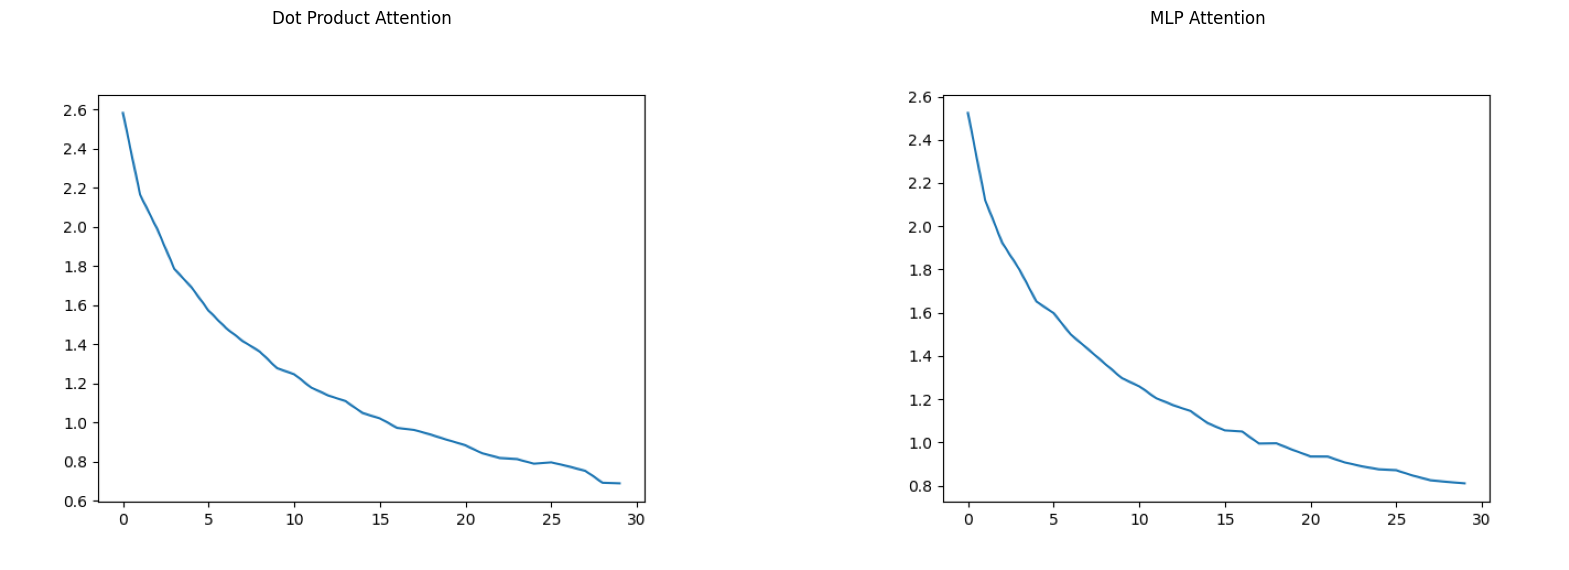

In [ ]:
img_dot = plt.imread('dot_product_attn_GRU_1_layer.png')
img_mlp = plt.imread('mlp_attn_GRU_1_layer.png')

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(img_dot)
plt.axis('off')
plt.title('Dot Product Attention')

plt.subplot(1, 2, 2)
plt.imshow(img_mlp)
plt.axis('off')
plt.title('MLP Attention')

plt.show()

# **Выводы**

## 1. Метрика качества в модели с механизмом внимания, основанным на косинусном сходстве, показала более лучший результат.  
## 2. Модель с механизмом внимания, основанным на косинусном сходстве, обучается быстрее, чем модель с MLP (примерно на 10 %)
## 3. На мой взгляд, фактический результат перевода лучше в модели, с использованием MLP, что особенно видно на графиках векторов внимания